# **CS282br Final Project**
Varshini Reddy,
Michael Cheng,
Matthew Nazari

In [1]:
import numpy as np
import numpy.random as npr
import pickle
import pandas as pd
# from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


**Datasets**
1. Cost $\in 13226 \times 2$
2. Pneumonia $\in 5856 \times 13228$
3. Pneumonia base $\in 1171 \times 13228$

In [2]:
# Datasets
dfs = dict(
  # pneumonia=pd.read_csv('data/pneumonia.csv', low_memory=False),
  # pneumonia_base=pd.read_csv('data/pneumonia_base_train.csv'),
  # unbalanced=pd.read_csv('data/total_data.csv'),
  balanced=pd.read_csv('data/balanced_data.csv'),
  clusters=[pd.read_csv(f'data/clusters/data_version{i}.csv') for i in range(10)],
  cost=pd.read_csv('data/cost.csv'),
  mean_features=pd.read_csv('data/mean_features.csv'),
)

In [5]:
# Dataframe utilites

## split a dataframe into x_train and y_train for logistic regression
def datafy (x: pd.DataFrame, y: pd.DataFrame):
  return x.values, y.values.ravel()

def split_df(df: pd.DataFrame, ignore_cols: list[str] = [], ret_df: bool = True):
  kept_cols = df.columns != 'class'
  for c in ignore_cols:
    kept_cols &= (df.columns != c)
  x, y = df.loc[:, kept_cols], df.loc[:, df.columns == 'class']
  return (x, y) if ret_df else datafy(x, y)

def random_rows(x: np.ndarray, y: np.ndarray, p: float):
  assert 0 <= p <= 1, "random_rows: invalid percentage"
  assert x.shape[0] == y.shape[0], "random_rows: x.shape[0] != y.shape[0]"
  idxs = npr.choice(x.shape[0], int(x.shape[0]*p), replace=False)
  return x[idxs, :], y[idxs]

# def logreg_score(x: np.ndarray, y: np.ndarray, p: float = 0.05):
#   x_train, y_train = random_rows(x, y, p)
#   lr = LogisticRegression().fit(x_train, y_train)
#   return lr.score(x, y)

**Rewards**

In [6]:
def get_updated_data(df: pd.DataFrame, features: list[str]):
    df = df.copy()
    for f in features:
        df[f] = dfs['mean_features'][f].item()            
    return df

lr_filename="data/logistic_model.sav"
lr_model = pickle.load(open(lr_filename, 'rb'))

def get_reward(features, df, model=lr_model):
    x, y = split_df(df)
    x = get_updated_data(x, features)
    x, y = datafy(x, y)
    y_pred = model.predict(x)
    reward = accuracy_score(y, y_pred)
    scale = 0.05
    cost = dfs['cost'][features].values.sum()**scale

    return (reward*100)/cost


**Feature Selection Algorithms**
- All features
- Random drop 50%
- Random drop 75%
- CMAB-GFS [(epubs.siam.org/doi/pdf/10.1137/1.9781611976700.36)](https://epubs.siam.org/doi/pdf/10.1137/1.9781611976700.36)

In [7]:
# Feature Selection Algorithms

## All features
all_features = lambda df: split_df(df)[0].columns

## Random drop 50% and 75%
def random_drop(df: pd.DataFrame, p: float):
  assert 0 <= p <= 1, "random_drop: invalid percentage"
  x, _ = split_df(df)
  return npr.choice(x.columns, x.shape[0]*p)

random_drop_50 = lambda df: random_drop(df, 0.50)
random_drop_75 = lambda df: random_drop(df, 0.75)

## CMAB-GFS
def generative_oracle (M, K, betas, eps):
  if npr.rand() < eps:
    return npr.choice(M, K)
  else:
    samples = {c: npr.beta(*params) for c, params in betas.items()}
    return [k for k, _ in sorted(samples.items(), key=lambda item: item[1], reverse=True)][:K]

def cmab_gfs(df, K, T, R, eps):
  assert 0 <= eps <= 1, "cmab_gfs: eps must be in [0, 1]"
  x, _ = split_df(df)
  M = x.columns
  betas = {c: (0.5, 0.5) for c in M}
  S_old = npr.choice(M, K)
  r_old = R(S_old)
  history = []
  for _ in tqdm(range(T)):
    S_new = generative_oracle(M, K, betas, eps)
    r_new = R(S_new)
    for i in np.union1d(S_old, S_new):
      a, b = betas[i]
      betas[i] = (a+1, b) if r_new > r_old else (a, b+1)
    S_old, r_old = S_new, r_new
    history.append(S_new)
  return history


In [ ]:
# Run CMAB-GFS algorithm for 10% .. 100% of features and save to './results/'
df = dfs['balanced']
x, _ = split_df(df)
total_features = len(x.columns)
for i in range(1, 11):
  K = int(i/10 * total_features)
  history = cmab_gfs(df, K=K, T=500, R=lambda f: get_reward(f, df), eps=0.10)
  with open(f'results/{i/10:.1f}_features_balanced.pickle', 'wb') as f:
    pickle.dump(history, f)
    

In [8]:
# Run clustered CMAB-GFS algorithm for 10% .. 100% of features and save to './results_clusters/'
clusters = dfs['clusters']
df_all = dfs['balanced']
for i in range(8, 11):
  print(f'Clustered CMAB-GFS for {i*10:.1f}% ...')
  total_history = []
  
  for df in clusters:
    x, _ = split_df(df)
    total_features = len(x.columns)
    K = int(i/10 * total_features)
    history = cmab_gfs(df, K=K, T=50, R=lambda f: get_reward(f, df_all), eps=0.10)
    if total_history == []:
      total_history = history
    else:
      total_history = [np.concatenate((x, y), axis=0) for x, y in zip(total_history, history)]
  
  with open(f'results_clusters/{i/10:.1f}_features.pickle', 'wb') as f:
    pickle.dump(total_history, f)


Clustered CMAB-GFS for 80.0% ...


100%|██████████| 50/50 [02:05<00:00,  2.51s/it]


Clustered CMAB-GFS for 90.0% ...


100%|██████████| 50/50 [02:07<00:00,  2.55s/it]


Clustered CMAB-GFS for 100.0% ...


100%|██████████| 50/50 [02:03<00:00,  2.46s/it]


In [ ]:
# Load results from './results/'
results = {}
for i in range(1, 11):
  with open(f'results/{i/10:.1f}_features.pickle', 'rb') as handle:
      results[i] = pickle.load(handle)


FileNotFoundError: [Errno 2] No such file or directory: 'plot_{i/10:.1f}_features.png'

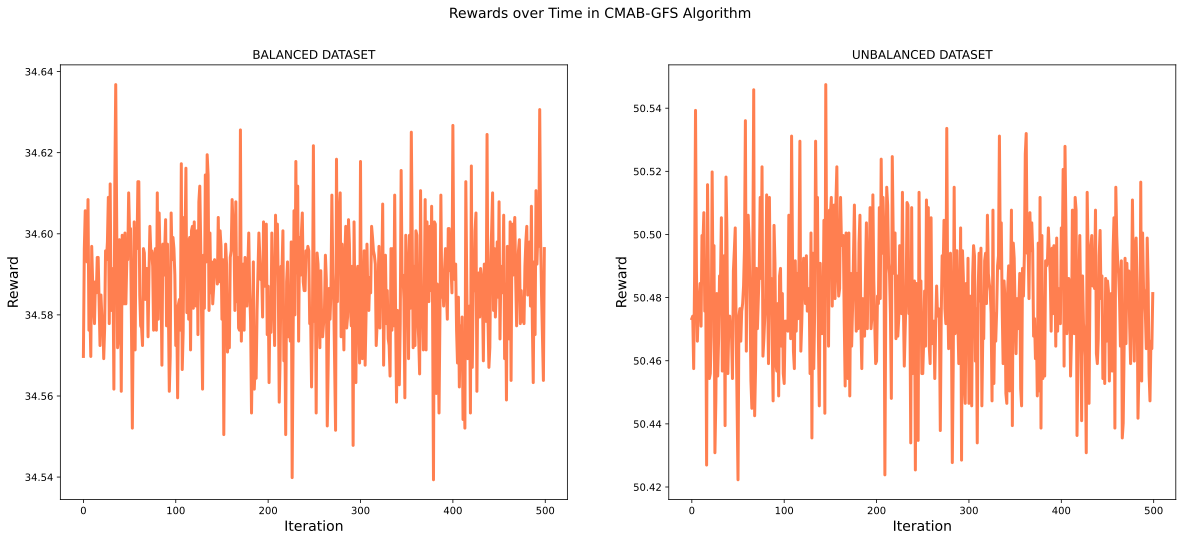

In [4]:
# color="#77D7C4", linewidth=3, fontsize of axis is 14

# times_balanced = [2.46, 2.75, 3.04, 2.88, 2.86, 2.93, 3.01, 3.16, 3.10, 3.21]
# times_unbalanced = [1.85, 1.92, 1.94, 1.93, 1.94, 1.98, 1.97, 2.27, 2.35, 2.43]
sizes = (np.arange(10)+1)/10


for i in range(1, 11):  
  fig, axs = plt.subplots(1, 2, figsize=(20, 8))

  with open(f'results/{i/10:.1f}_features_balanced.pickle', 'rb') as handle:
    d1 = pickle.load(handle)
  with open(f'results/{i/10:.1f}_features.pickle', 'rb') as handle:
    d2 = pickle.load(handle)
    
  history1, history2 = [], []
  for x in d1:
    if type(x) == dict:
      history1.append(x['reward'])
  
  for x in d2:
    if type(x) == dict:
      history2.append(x['reward'])


  axs[0].plot(history1, linewidth=3, c='coral')
  axs[0].set_xlabel('Iteration', fontsize=14)
  axs[0].set_ylabel('Reward', fontsize=14)
  axs[0].set_title("BALANCED DATASET")

  axs[1].plot(history2, linewidth=3, c='coral')
  axs[1].set_xlabel('Iteration', fontsize=14)
  axs[1].set_ylabel('Reward', fontsize=14)
  axs[1].set_title("UNBALANCED DATASET")

  fig.suptitle('Rewards over Time in CMAB-GFS Algorithm', fontsize=14)
  plt.savefig(f'plot_{i/10:.1f}_features.png', dpi=300)